In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pandas as pd
from scipy.fftpack import fft, ifft, fftshift, rfftfreq, rfft, irfft
%matplotlib inline
import pandas as pd
import pywt
import torch
import plotly.graph_objects as go
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

# ЗАДАНИЕ 5

## Фурье преобразование

### FFT

In [5]:
def FFT(P):
    """ Функция реализует быстрое преобразование Фурье
    
    P - список сигналов"""
    
    n = len(P)
    if n == 1:
        return P
    else:
        w = np.exp((2*np.pi*1j)/n)
        Pe = [P[2*k] for k in range(int(n/2))]
        P0 = [P[2*k + 1] for k in range(int(n/2))]
        ye = FFT(Pe)
        y0 = FFT(P0)
        y = [0]*n
        for j in range(int(n/2)):
            y[j] = ye[j] + w**j*y0[j]
            y[j + int(n/2)] = ye[j] - w**j*y0[j]
        return y

### Пример использования

In [6]:
FFT([5, 3, 2, 1, 17, 7, 3, 6])

[(44+0j),
 (-11.292893218813452-7.363961030678928j),
 (17+3.000000000000001j),
 (-12.707106781186548-5.363961030678929j),
 (10+0j),
 (-12.707106781186548+5.363961030678928j),
 (17-3.000000000000001j),
 (-11.292893218813452+7.363961030678929j)]

### Коэфициент несинусоидальности

In [7]:
def coefficient(sample, sample_name):
    
    """Функция считает коэфициент несинусоидальности
    sample - список сигналов (выборка)
    sample_name - название выборки"""
    
    peaks = np.abs(rfft([i[1] for i in sample]))
    index = np.argmax(peaks)
    span = []
    pr = (sample.shape[0] - 1)/(sample[-1][0] - sample[0][0])
    for i in range(1, sample.shape[0]//2):
        x = rfftfreq(sample.shape[0], 1/pr)[i]
        f = np.abs(rfft([item[1] for item in sample]))[i]
        span.append([x, f])
    Si = 0
    intr = span[2][0] - span[0][0]
    S0 = ((peaks[index-1] + peaks[index+1])/2 + peaks[index])*intr
    for i in range(1, peaks.size):
        Si += (peaks[i-1] + peaks[i])/2*intr
    Si -= S0
    print(f' coefficient {sample_name} =  {Si/S0}')

### Пример использования

In [8]:
df =  np.array(pd.read_csv('Test_sin.csv'))
df2 = np.array(pd.read_csv('Line.csv'))
df3 = np.array(pd.read_csv('sin_peak.csv'))
df4 = np.array(pd.read_csv('2_sin_5_4.5.csv'))
list_df = [df, df2, df3, df4]
list_name = ['Test_sin.csv', 'Line.csv', 'sin_peak.csv', '2_sin_5_4.5.csv']
for k in range(4):
    coefficient(list_df[k], list_name[k])

 coefficient Test_sin.csv =  9.671568578491538
 coefficient Line.csv =  -0.5
 coefficient sin_peak.csv =  10.489178401265473
 coefficient 2_sin_5_4.5.csv =  3.6175078518389987


### Построение графика сигналов, спектрограммы и восстановленного графика

In [9]:
def plot_spectrum(sample, sample_name):
    
    """Функция считает коэфициент несинусоидальности
    sample - список сигналов (выборка)
    sample_name - название выборки"""
    
    # spectrum
    span = []
    pr = (sample.shape[0] - 1)/(sample[-1][0] - sample[0][0])
    for i in range(1, sample.shape[0]//2):
        x = rfftfreq(sample.shape[0], 1/pr)[i]
        f = np.abs(rfft([item[1] for item in sample]))[i]
        span.append([x, f])
    fig, axs = plt.subplots(1, 1, figsize=(9, 4))
    plt.plot([i[0] for i in span], [i[1] for i in span])
    plt.grid(True)
    plt.xlabel('Frequency')
    plt.ylabel('y_points')
    plt.title(f'Spectrum {sample_name}')
    plt.show()
    
    # beggining function
    fig, axs = plt.subplots(1, 1, figsize=(9, 4))
    plt.plot([el[0] for el in df], [el[1] for el in df])
    plt.grid(True)
    plt.title(f" Original function {sample_name}")
    plt.xlabel('x_points')
    plt.ylabel("y_points")
    
    # restart function
    fig, axs = plt.subplots(1, 1, figsize=(9, 4))
    peaks = list(np.abs(rfft([item[1] for item in sample])))
    rest = irfft(peaks)
    plt.plot(rest)
    plt.grid(True)
    plt.title(f"Restored function {sample_name}")
    plt.xlabel("x_points")
    plt.ylabel("y_points") 

### Пример использования

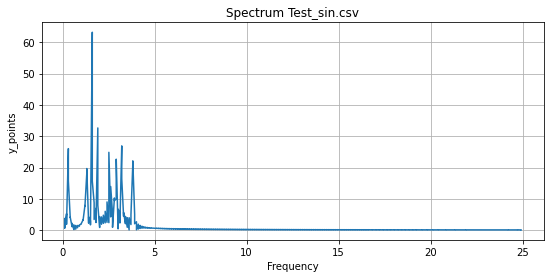

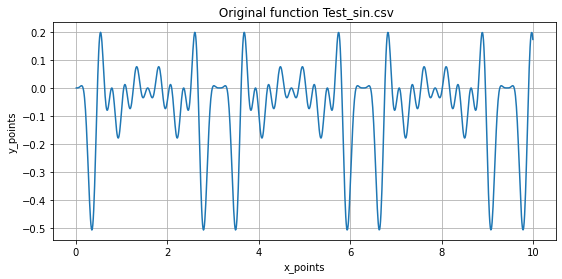

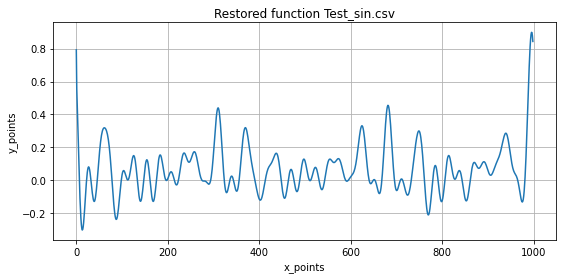

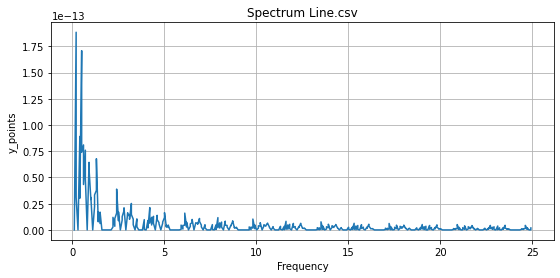

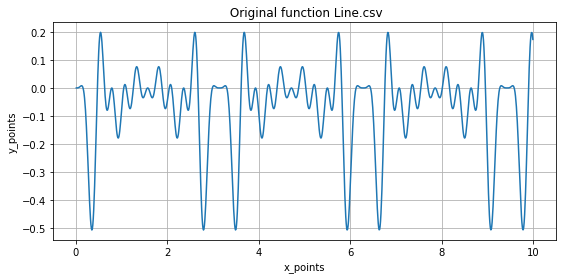

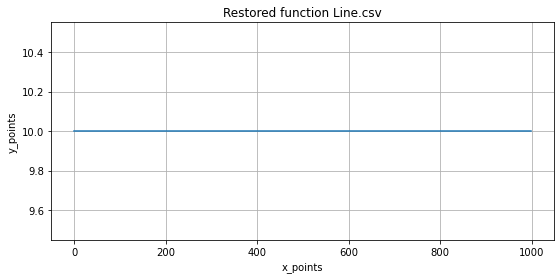

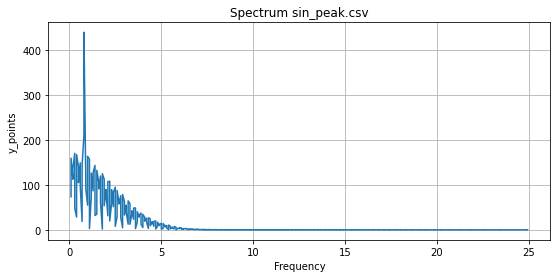

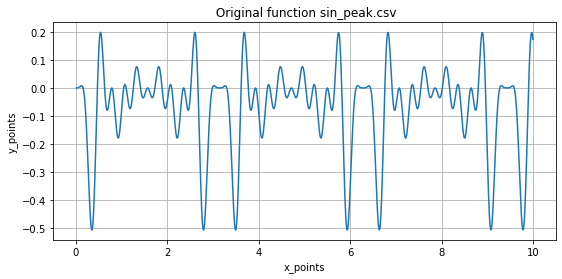

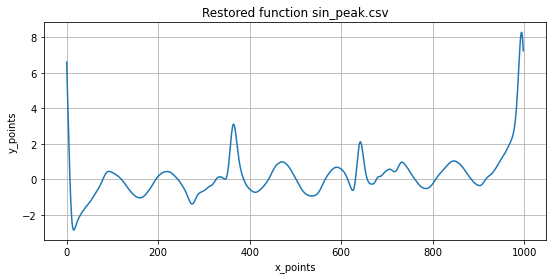

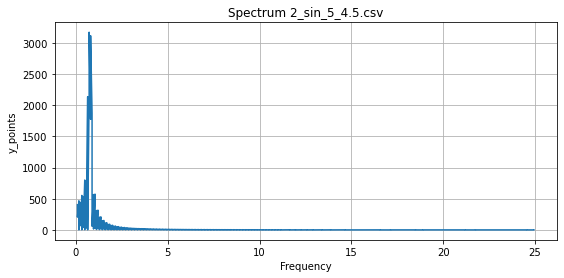

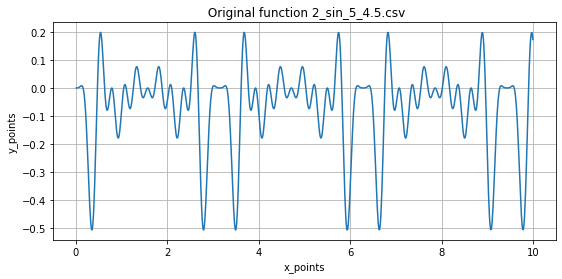

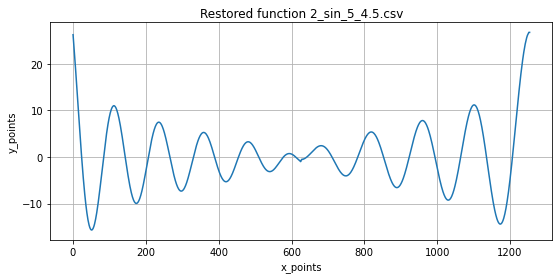

In [10]:
for k in range(4):
    plot_spectrum(list_df[k], list_name[k])

### Расчет дисперсии

In [11]:
def variation(sample, sample_name):
    
    """Функция считает отклонение реальных данных от данных, получившихся в результате преобразование Фурье
    sample - список сигналов (выборка)
    sample_name - название выборки"""
    
    peaks = list(np.abs(rfft([item[1] for item in sample])))
    exmp = irfft(peaks)
    y = [line[1] for line in sample]
    var = sum([(y[i]-exmp[i])**2 for i in range(len(exmp))])
    print(f'variation {sample_name} : {var}')

### Пример использования

In [12]:
for k in range(4):
    variation(list_df[k], list_name[k])

variation Test_sin.csv : 45.52106653660883
variation Line.csv : 1.072850831100576e-28
variation sin_peak.csv : 4335.61089569945
variation 2_sin_5_4.5.csv : 111595.3622301852


### Эксперимент: отрезать по 10% от частотного спектра и построить графики восстановленной функции по спектрограмме.

In [13]:
def restart(lst, name): 
    
    """Функция восстановливает функции по спектрограмме
    lst - список сигналов"""

    period = (len(lst)-1)/(lst[-1][0] - lst[0][0])
    spektor = []
    for i in range(1, len(lst)//2):
        y = np.abs(rfft([el[1] for el in lst]))[i]
        x = rfftfreq(len(lst), 1/period)[i]
        spektor.append([x,y])
    peaks_n = np.abs(rfft([el[1] for el in lst]))
    peaks = list(peaks_n)
    part = len(lst)//10
    part_sp = len(spektor)//10
    fig, axs = plt.subplots(10, 3, figsize=(15, 30))
    plt.subplots_adjust(wspace=2, hspace=0.7)
    def plot_restart(i, n, n_sp):
       
        """Функция строит графики восстановленной функции по спектрограмме
        i - итерация, необходимая для определения длины отрезанного сигнала
        n - граница списка сигналов
        n_sp - граница списка спектров"""
        
        axs[i-1, 0].plot([el[0] for el in lst], [el[1] for el in lst])
        axs[i-1, 0].plot([el[0] for el in lst[:n]], [el[1] for el in lst[:n]], 'r')
        axs[i-1, 0].grid(True)
        axs[i-1, 0].set_title(f"Original function {name}")
        axs[i-1, 0].set_xlabel(f"x")
        axs[i-1, 0].set_ylabel(f"y")

        axs[i-1, 1].plot([el[0] for el in spektor[:n_sp]], [el[1] for el in spektor[:n_sp]])
        axs[i-1, 1].grid(True)
        axs[i-1, 1].set_title(f"Spectrum {name} (cup part {(i-1)*10}%)")
        axs[i-1, 1].set_xlabel('Frequency (Гц)')
        axs[i-1, 1].set_ylabel('Points')

        recover = irfft(peaks[:n])
        axs[i-1, 2].plot(recover)
        axs[i-1, 2].grid(True)
        axs[i-1, 2].set_title(f"Restart function {name}")
        axs[i-1, 2].set_xlabel(f"x")
        axs[i-1, 2].set_ylabel(f"y")
    
    for i in range(1,11):
        plot_restart(i, part*(11-i), part_sp*(11-i))

### Пример использования

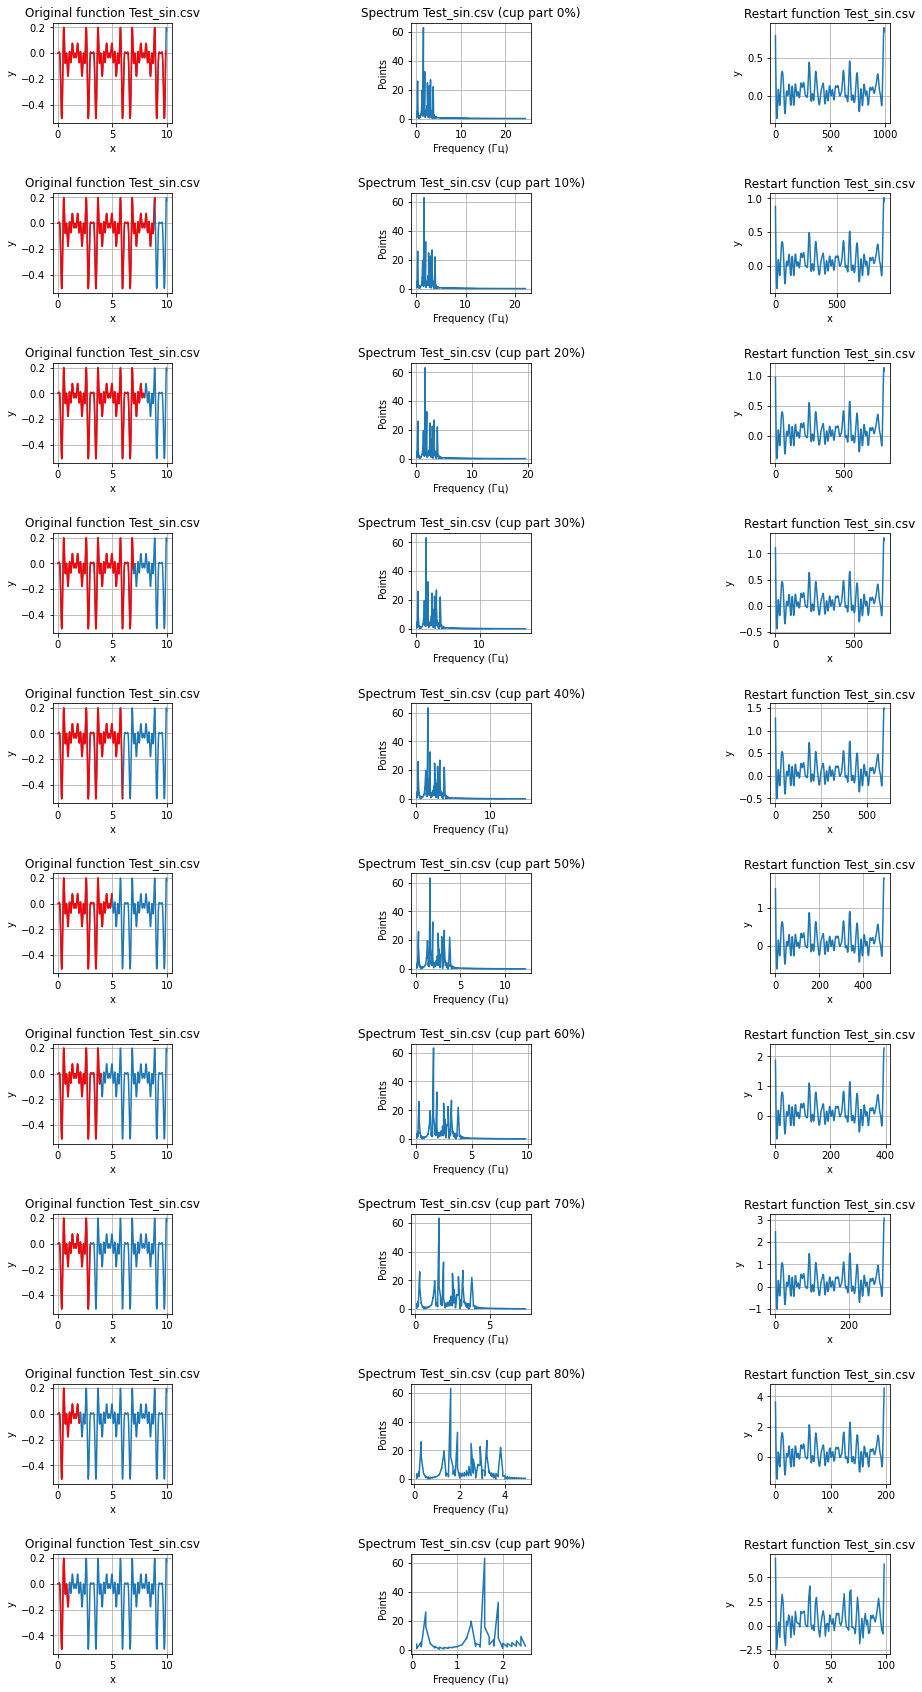

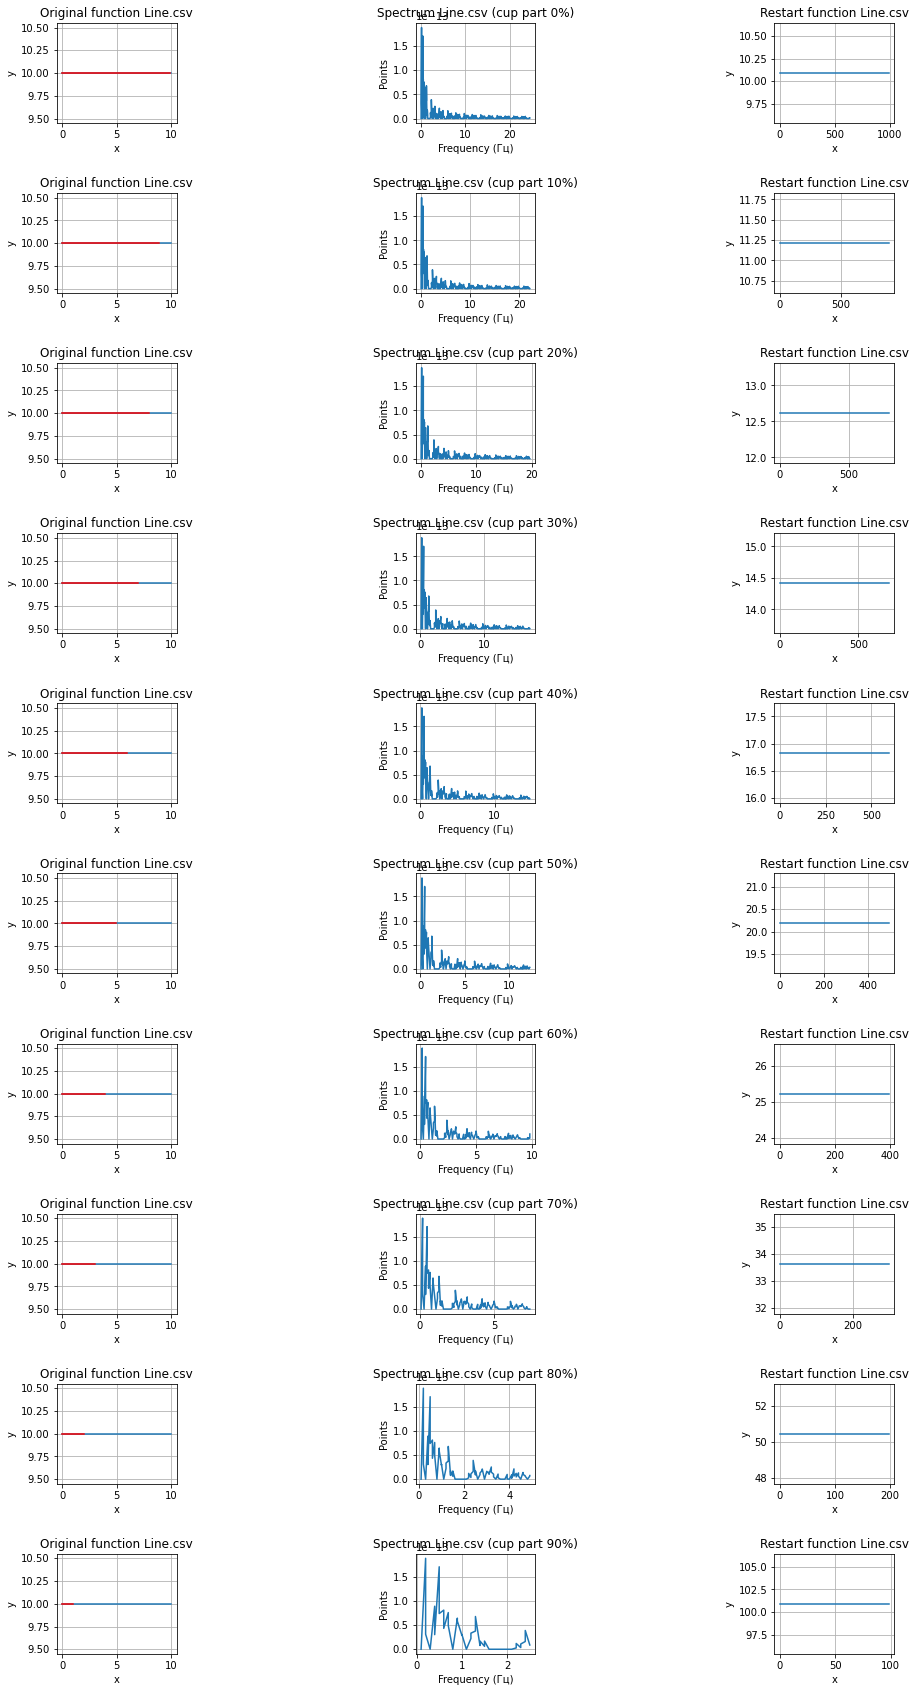

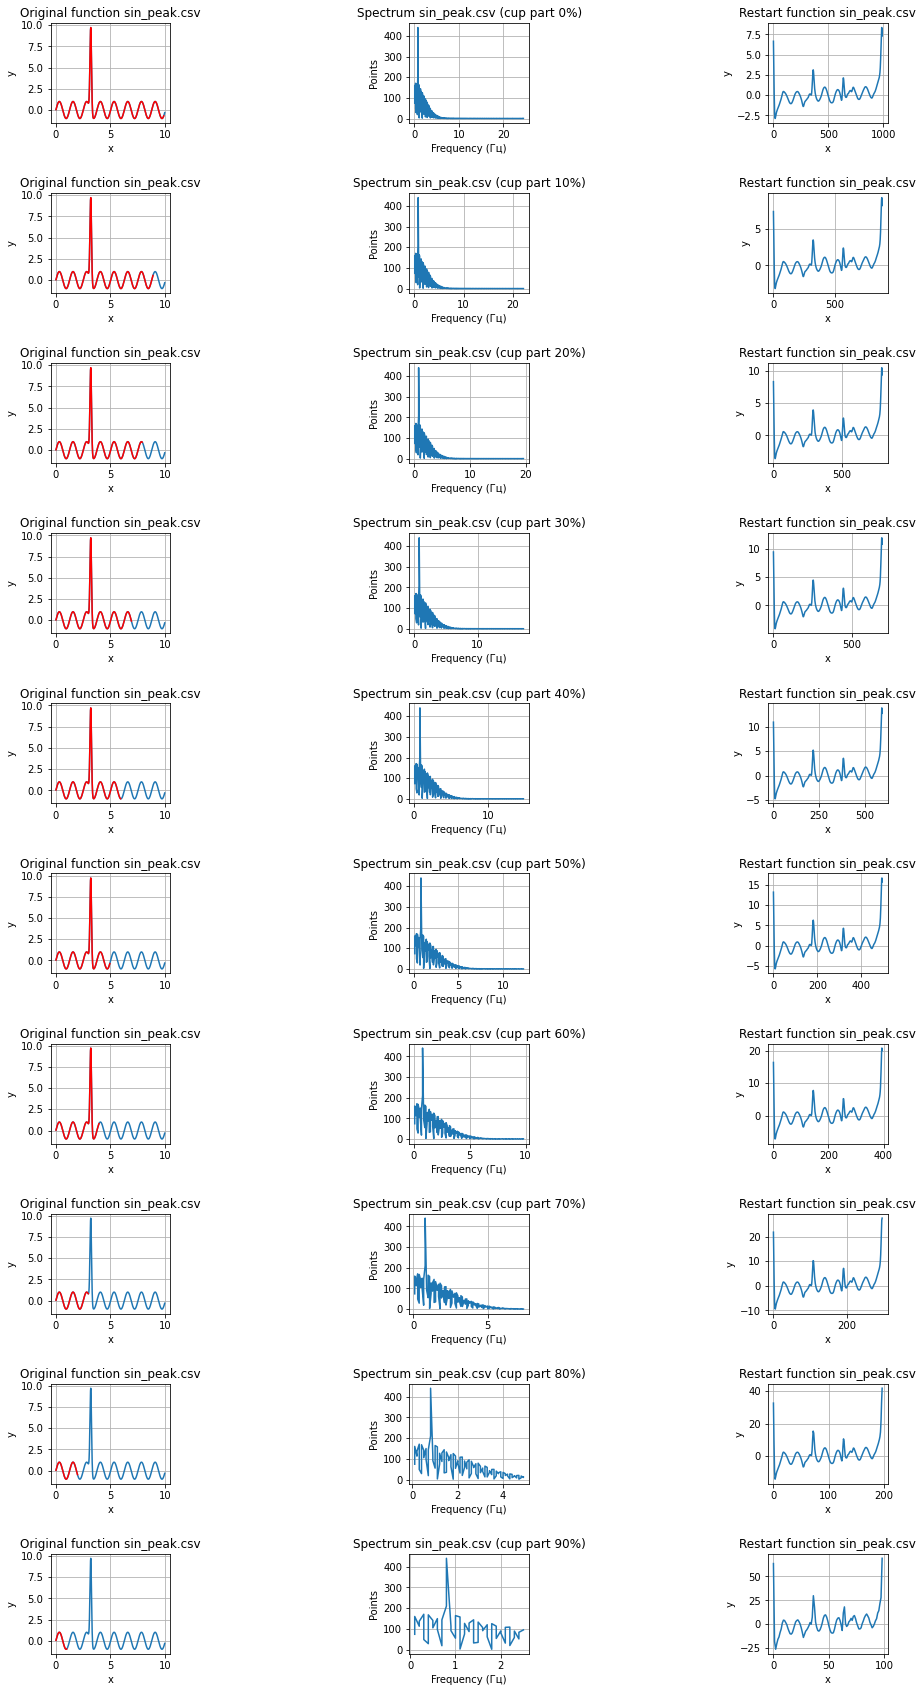

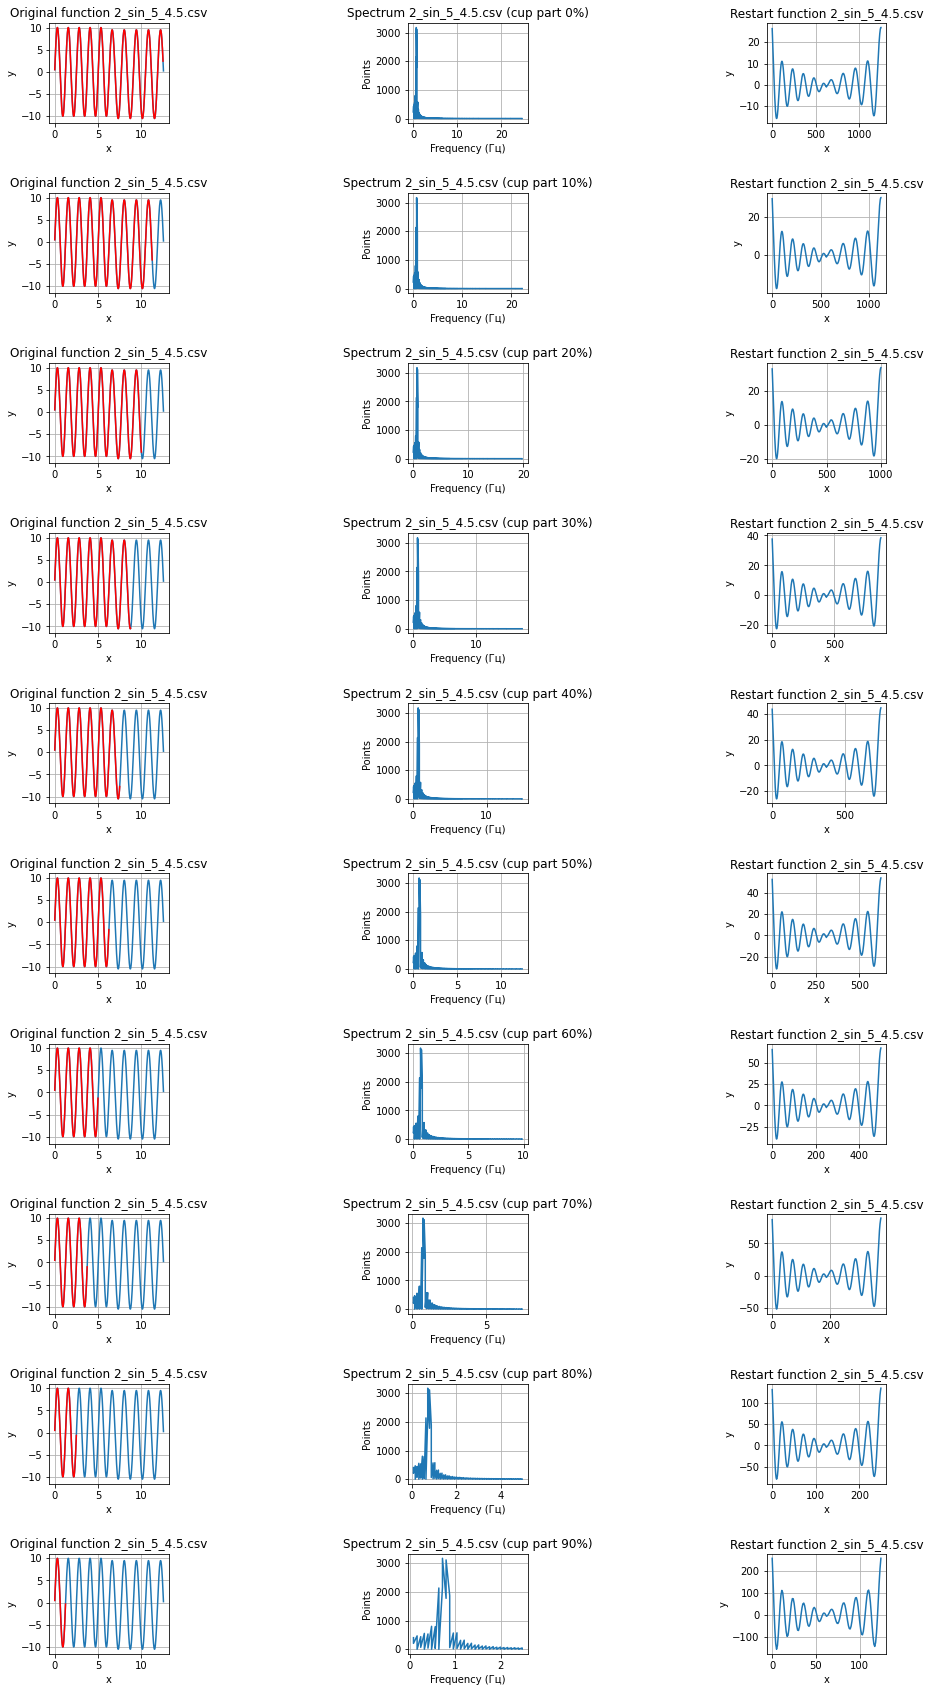

In [14]:
for i in range(len(list_df)):
    restart(list_df[i], list_name[i])

## Вейвлет - преобразование

### Вейвлет - декомпозиция 1 до n - го уровня (descrete wavelet transform)

In [15]:
def descrete_decomposition(num_levels, y, name_sample):
    
    """Функция выводит Вейвлет-декомпозиции до уровня n
        num_levels - количество уровней декомпозиции
        y - список сигналов
        name_sample - названия списка сигналов"""
    
    for wev in ['haar', 'db2']:
        x = np.append(0, np.array(pd.read_csv(name_sample))[:, :1])
        plt.plot(x, y, 'orange')
        plt.grid(True)
        plt.title(f" {name_sample} : Исходная функция - {wev}")
        plt.show()
        for i in range(1, num_levels+1):
            # коэфициенты аппроксимации (выход фильтра нижних частот)
            coeffs = pywt.wavedec(y, wev, level=i)
            plt.subplot(2,1,1)
            plt.title(f'{name_sample} : Вейвлет - {wev}, декомпозиция {i}-ого уровня')
            plt.plot(coeffs[0], 'b', linewidth=2, label = f'cA, level={i}')
            plt.grid()
            plt.legend(loc = 'best')
            plt.show()
            # коэфициенты детализации (выход фильтра высоких частот)
            plt.subplot(2,1,2)
            plt.plot(coeffs[1], 'r', linewidth=2, label = f'cD, level={i}')
            plt.grid()
            plt.legend(loc = 'best')
            plt.show()

### Пример использования

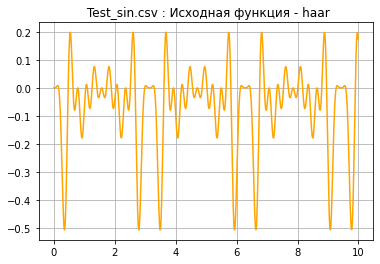

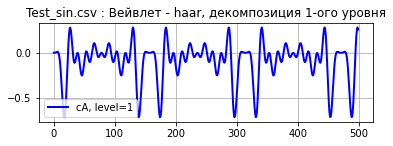

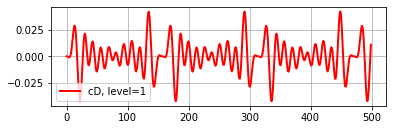

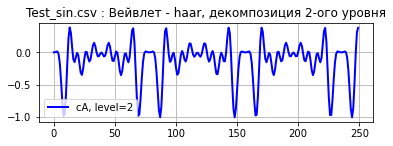

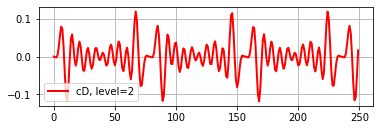

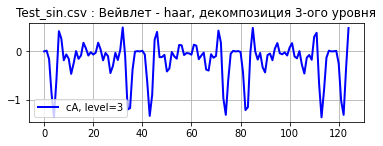

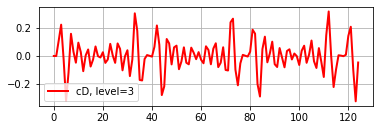

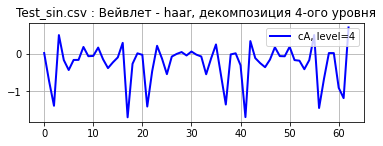

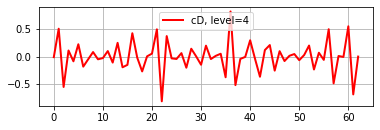

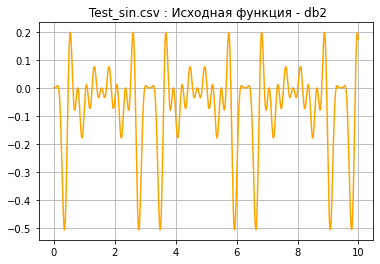

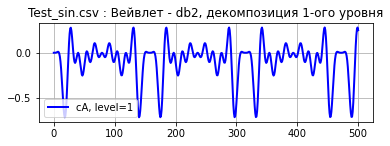

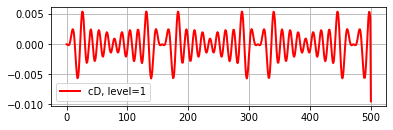

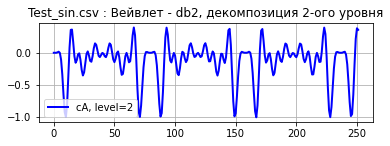

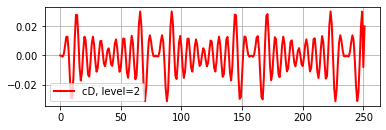

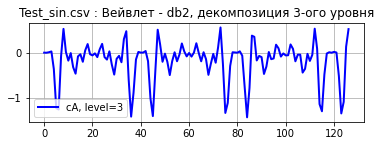

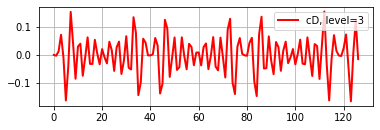

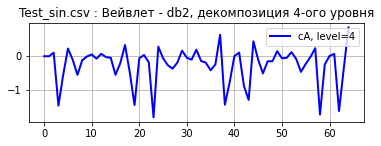

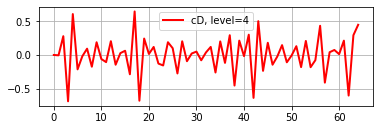

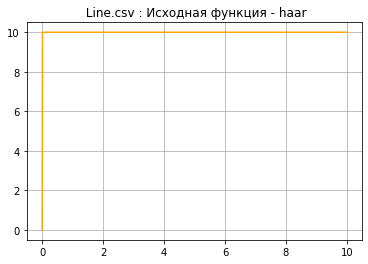

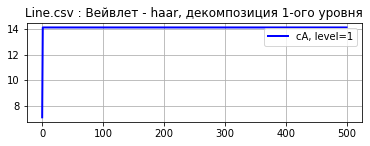

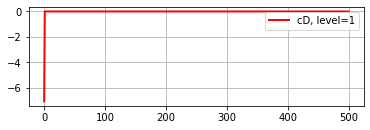

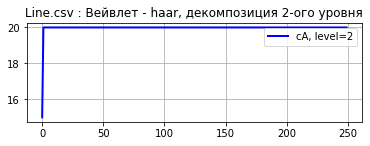

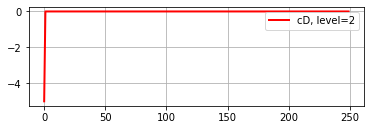

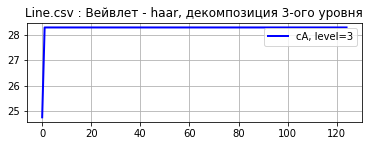

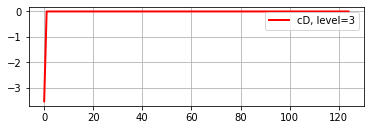

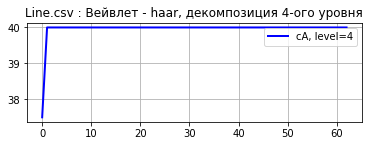

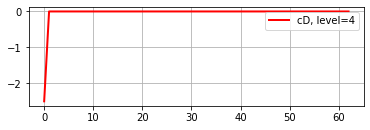

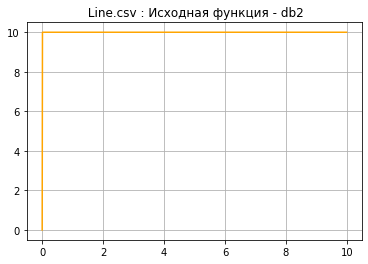

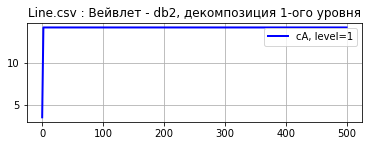

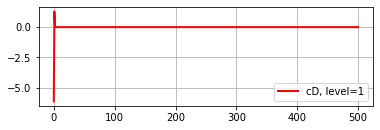

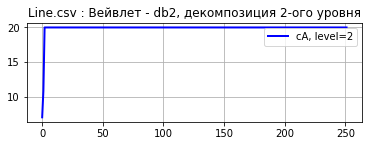

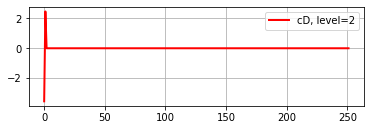

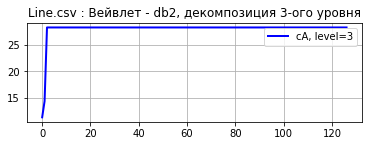

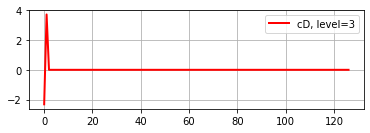

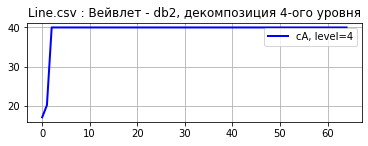

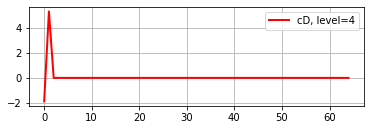

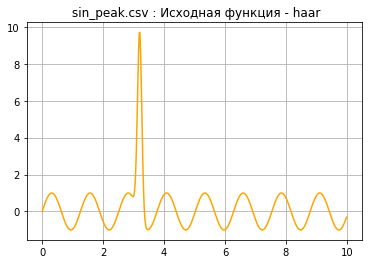

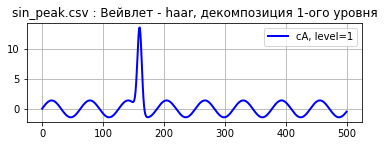

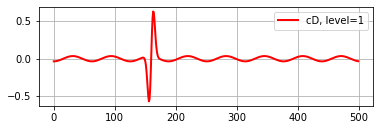

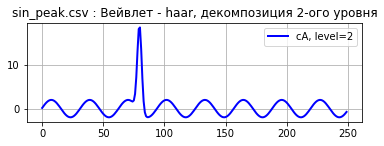

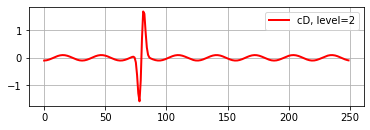

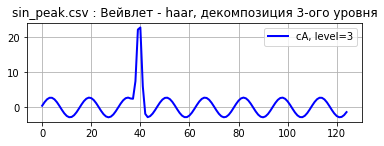

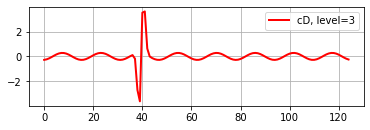

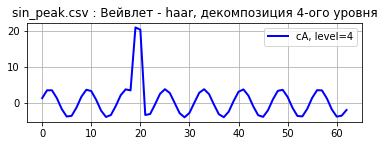

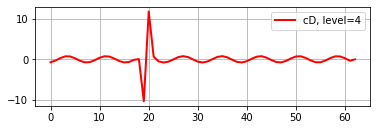

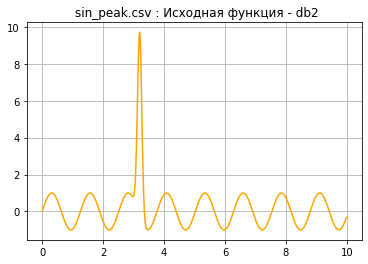

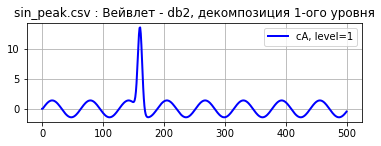

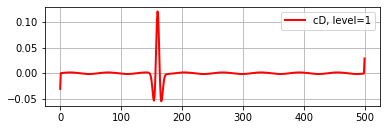

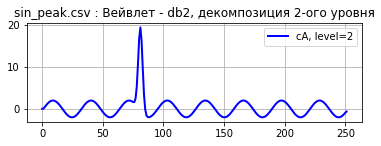

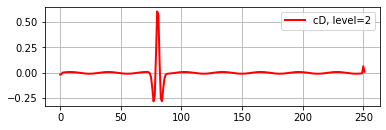

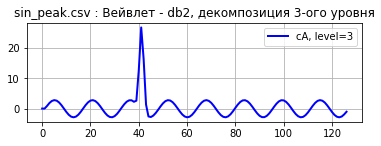

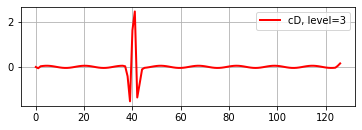

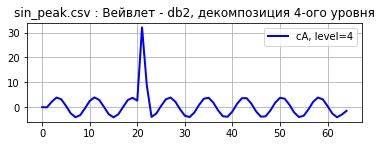

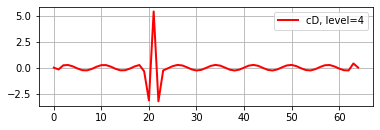

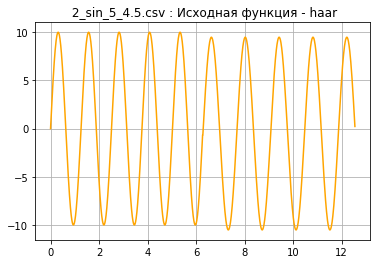

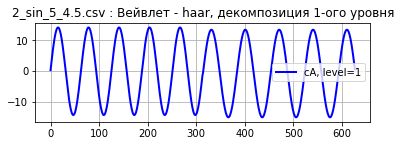

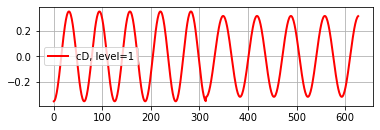

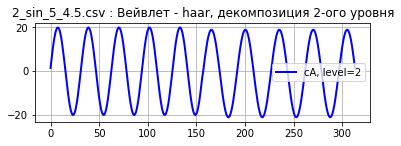

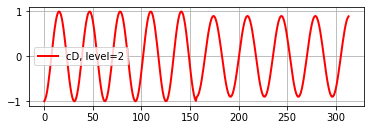

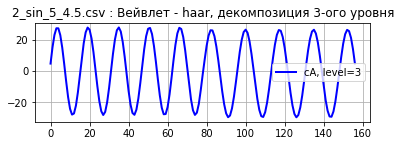

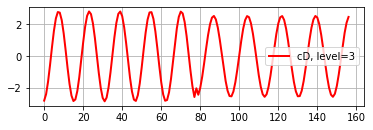

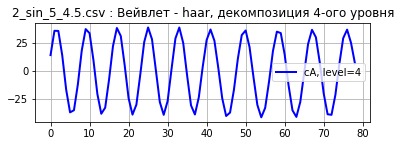

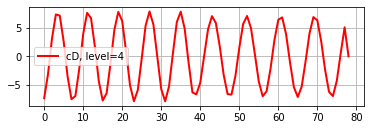

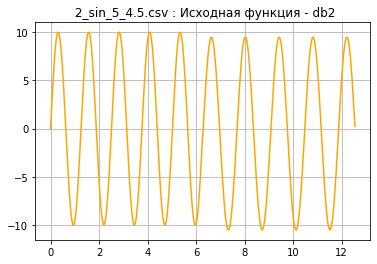

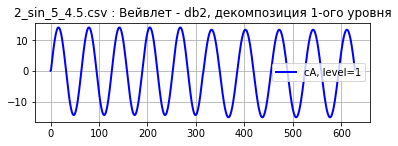

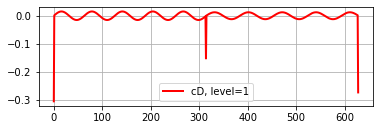

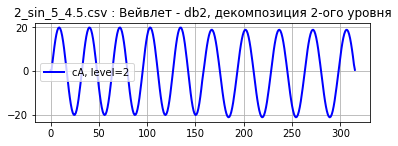

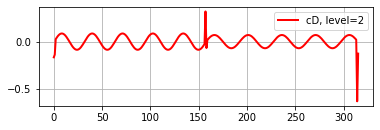

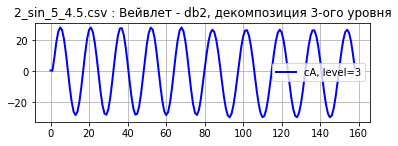

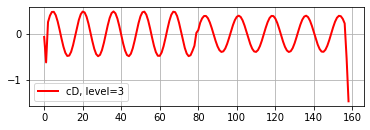

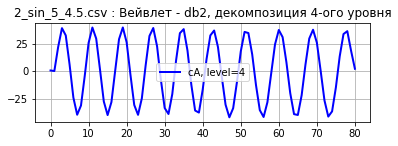

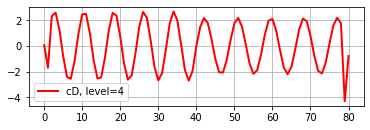

In [16]:
df  = np.append(0, np.array(pd.read_csv('Test_sin.csv'))[:, 1:])
df2 = np.append(0, np.array(pd.read_csv('Line.csv'))[:, 1:])
df3 = np.append(0, np.array(pd.read_csv('sin_peak.csv'))[:, 1:])
df4 = np.append(0, np.array(pd.read_csv('2_sin_5_4.5.csv'))[:, 1:])
list_df = [df, df2, df3, df4]
list_name = ['Test_sin.csv', 'Line.csv', 'sin_peak.csv', '2_sin_5_4.5.csv']
for k in range(4):
    descrete_decomposition(4, list_df[k], list_name[k])

### Вейвлет - декомпозиция 1 до n-го уровня (continuous wavelet transform)

In [17]:
def count_level(func, wavelet):
    
    """Функция возвращает массивы аппроксимации и детализации 
    func - список сигналов
    wavelet - название вейвлета"""
    
    a, b = pywt.cwt(func, np.arange(1,4), wavelet)
    return a, b

def cont_decomposition(num_levels, y, name_sample):
    
    """Функция выводит Вейвлет-декомпозиции до уровня n
    num_levels - количество уровней декомпозиции
    y - список сигналов
    name_sample - названия списка сигналов"""
    
    for wev in ['gaus1', 'mexh']:
        x = np.append(0, np.array(pd.read_csv(name_sample))[:, :1])
        plt.plot(x, y, 'orange')
        plt.grid(True)
        plt.title(f" {name_sample} : Исходная функция - {wev}")
        plt.show()
        for i in range(1, num_levels+1):
            wavelet = pywt.ContinuousWavelet(wev, level = i)
            coef, freqs = count_level(y, wavelet)
            if i == 1:
                plt.subplot(2,1,1)
                plt.title(f' {name_sample}: Вейвлет - {wev}, декомпозиция {i}-ого уровня')
                plt.plot(coef[0], label = f' level={i}')
                plt.grid()
                plt.legend(loc = 'best')
                plt.show()
            else:
                for k in range(2, i+1):
                    coef, freqs = count_level(coef[0], wavelet)
                plt.subplot(2,1,1)
                plt.title(f' {name_sample}: Вейвлет - {wev}, декомпозиция {i}-ого уровня')
                plt.plot(coef[0], label = f' level={i}')
                plt.grid()
                plt.legend(loc = 'best')
                plt.show()
                

### Пример использования

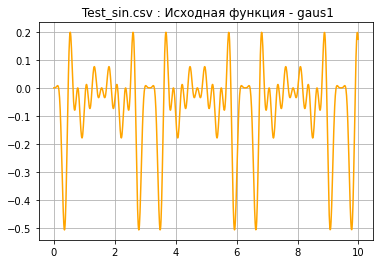

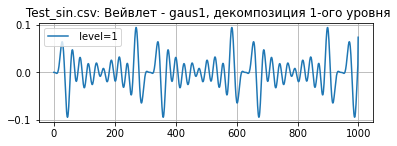

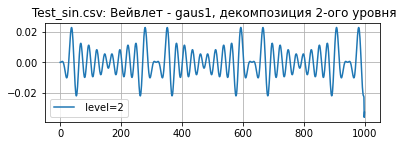

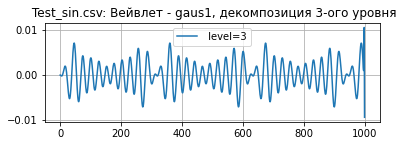

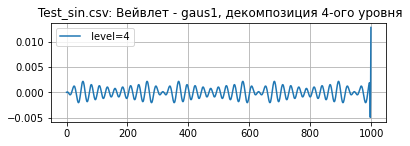

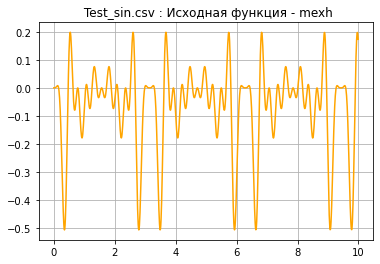

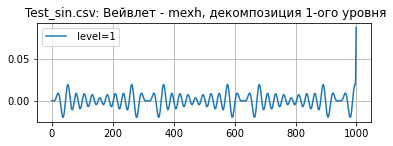

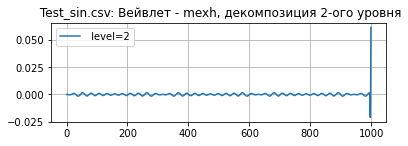

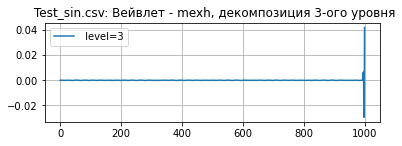

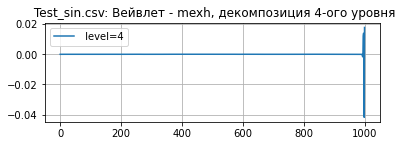

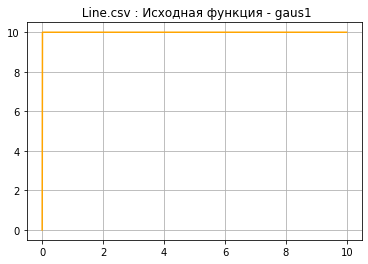

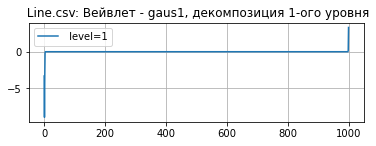

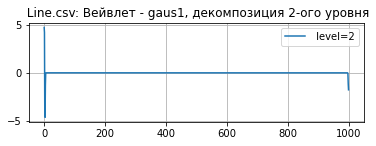

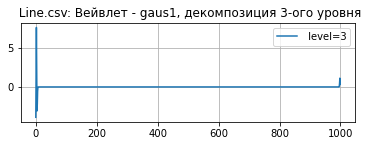

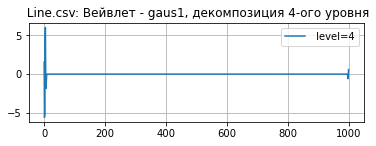

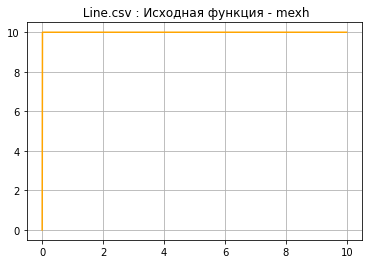

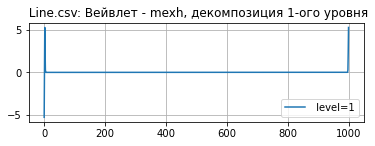

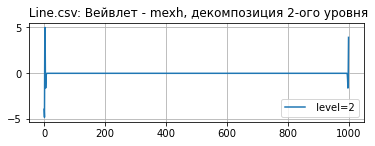

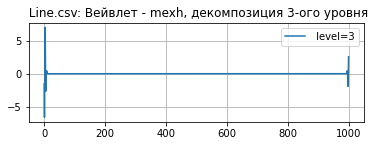

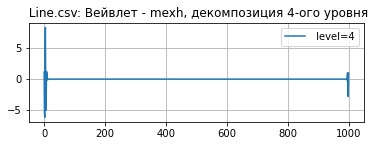

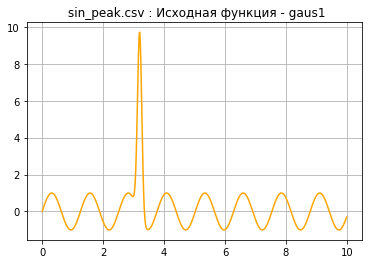

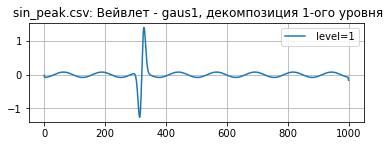

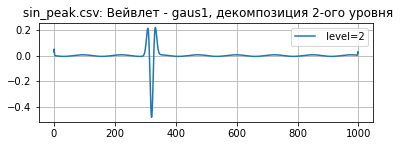

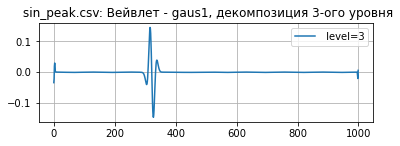

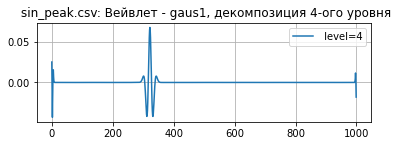

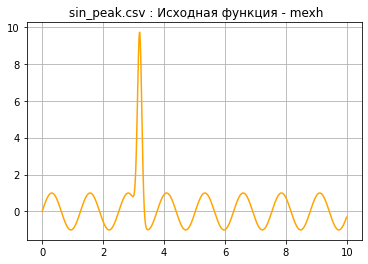

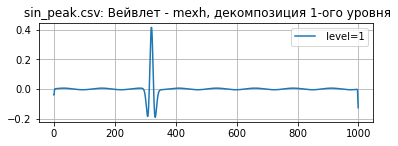

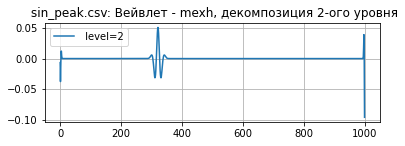

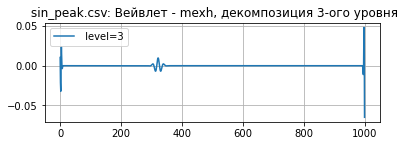

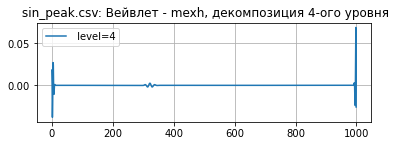

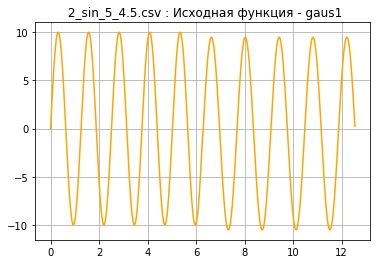

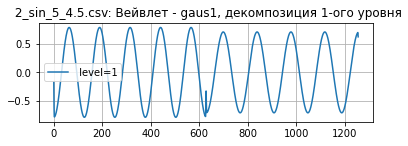

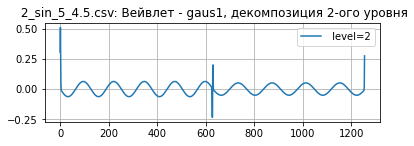

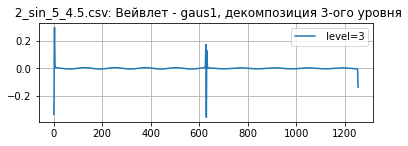

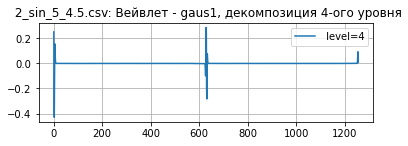

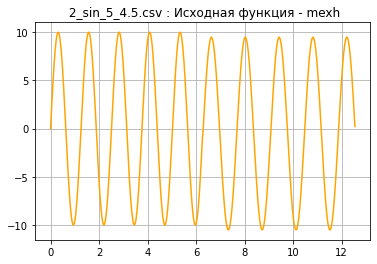

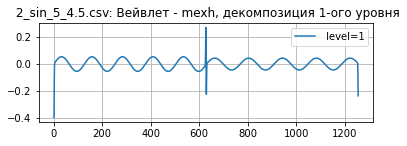

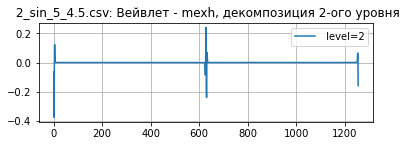

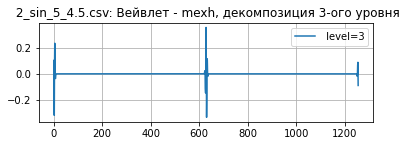

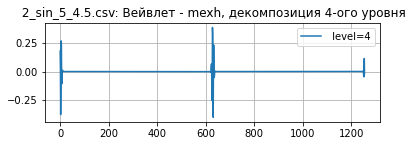

In [18]:
for k in range(4):
    cont_decomposition(4, list_df[k], list_name[k])

## Аппроксимация нейронной сетью

In [19]:
class Model(nn.Module):
    def __init__(self, in_feats, h_feats, out_feats):        
        super(Model, self).__init__()     # конструктор предка с этим именем
         
        self.fc1 = nn.Linear(in_feats, h_feats)             # создаём параметры модели
        self.fc2 = nn.Linear(h_feats, out_feats)             # в полносвязных слоях
          
    def forward(self, h):                        # задаётся прямой проход
        h = self.fc1(h)                          # выход первого слоя
        h = nn.Sigmoid()(h)         # пропускаем через Sigmoid
        h = self.fc2(h)
                        # выход второго слоя     
        return h

In [20]:
def Approximation(features, y, n_epochs, in_feats, h_feats, out_feats, N):
    
    """Функция аппроксимирует данную функцию
    features - значение аргумента функции
    y - список желаемых значений
    n_epoches - названия списка сигналов
    in_feats - количество входных слоев
    h_feats - количество скрытых слоев
    out_feats - количество выходных слоев
    N - число, определяющее границу выборки"""
    
    x = np.linspace(0, N, N)
    x.shape = 100, 1

    model = Model(in_feats, h_feats, out_feats) 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.4)
    criterion = torch.nn.MSELoss()

    for epoch in range(n_epochs):

        optimizer.zero_grad() 
        # Forward
        pred = model(features)
        loss = criterion(pred.view(-1, 1), y2.view(-1, 1))

        # Вычисляем потери
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('In epoch {}, loss: {}'.format(epoch, loss))
            
    # рисуем нашу исходную функцию
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = features.flatten().numpy(),
                                 y = y2.flatten().numpy(),
                                 mode = 'markers',
                                name = 'input_function'))

    # Генерируем  прогнозы для равномерно распределенных значений x между min и max
    min_x = min(list(features.numpy()))
    max_x = max(list(features.numpy()))
 
    z = torch.from_numpy(np.linspace(min_x, max_x, num = len(features))).reshape(-1, 1).float()
    w = model(z)

    # рисуем предсказанную функцию
    fig.add_trace(go.Scatter(x = z.flatten().numpy(),
                                 y = w.flatten().detach().numpy(),
                                 mode = 'lines',
                                name = 'predicted'))

    fig.show()

### Пример использования

In [22]:
N = 100
in_feats = features.shape[1]
features = torch.tensor(np.array(pd.read_csv('XY_3.csv'))[:, :1][:N], dtype=torch.float32)
y2 = torch.tensor(np.array(pd.read_csv('XY_3.csv'))[:, 1:][:N], dtype=torch.float32)

NameError: name 'features' is not defined

In [ ]:
Approximation(features, y2, 10000, in_feats, 512, 1, 100)